# Non-parametric regression (Cubic splines)

The motorcycle dataset records the head's acceleration after an accident as a function of time.

Made by : 
* Mohamed JARMOUNI
* Amine AZAMMAM

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/hichamjanati/hichamjanati.github.io/master/_data/Motorcycledata.txt"
names = ["x", "y"]
df_raw = pd.read_csv(url, index_col=0, delim_whitespace=True, names=names)
print(df_raw.shape)
df_raw.head()

(133, 2)


,x,y
1,2.4,0.0
2,2.6,-1.3
3,3.2,-2.7
4,3.6,0.0
5,4.0,-2.7


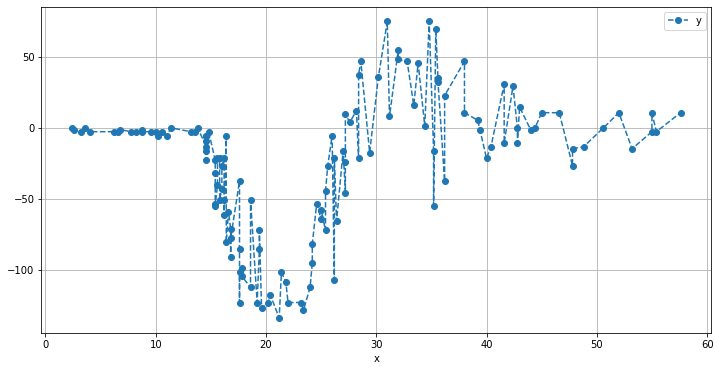

In [58]:
ax = df_raw.plot("x", "y", marker="o", ls="--", figsize=(12, 6))
ax.grid()

Transform the data to variables $(x, y, w)$ such that duplicated values are handled and ready to be fed to a weighted spline regression (cf TD Questions 5-6). 

In [59]:
grouped_df = df_raw.groupby("x", as_index=False).agg({"y": ["mean", "count"]})
grouped_df.columns = ["_".join(col).strip() for col in grouped_df.columns.values]
grouped_df.columns = ["x", "y", "w"]
grouped_df

,x,y,w
0,2.4,0.0,1
1,2.6,-1.3,1
2,3.2,-2.7,1
3,3.6,0.0,1
4,4.0,-2.7,1
...,...,...,...
89,52.0,10.7,1
90,53.2,-14.7,1
91,55.0,4.0,2
92,55.4,-2.7,1


### Polynomial regression
Polynomial regression (fitting a best polynomial on the data) can be done using `np.polyfit` to obtain the coefficients and `polyval` to evaluate it.

We perform (weighted) polynomial regression on the data and visualize the fitted curves for degrees 1, 3, 10 on the same plot. Try higher degree polynomial fits. Besides overfitting, why is this potentially a bad idea ?

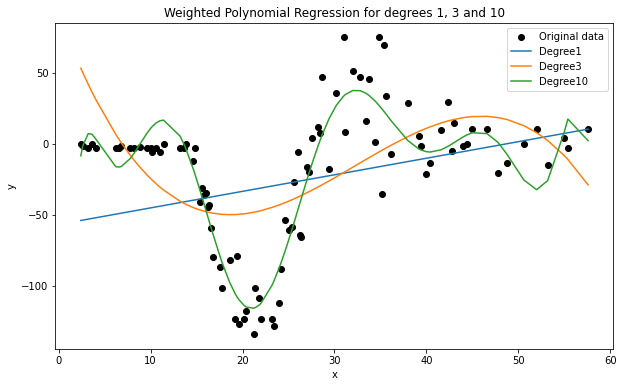

In [60]:
x = grouped_df["x"].values
y = grouped_df["y"].values
w = grouped_df["w"].values

plt.figure(figsize=(10, 6))

plt.scatter(x, y, c='black', label='Original data')

for deg in [1, 3, 10]:
    coef = np.polyfit(x, y, deg, w=w)
    curve = np.polyval(coef, x)
    
    plt.plot(x, curve, label="Degree"+ str(deg))

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Weighted Polynomial Regression for degrees 1, 3 and 10')
plt.show()

## Cubic spline regression
the function `solve_splines_naive` computes $g$ and $\gamma$ given the data. 
 
Knowing that $R + \alpha Q^\top Q$ is invertible,  `solve_splines`  performs 0 matrix inversions.

In [61]:
from scipy.linalg import cho_factor, cho_solve

In [62]:
def _construct_R_Q(x):
    """Function that constructs the matrices R and Q given the knots x_i."""
    n = len(x)
    h = np.diff(x)
    R = np.zeros((n-2, n-2))
    Q = np.zeros((n, n))
    
    # construct R
    indx = np.arange(n)
    # diag elements
    R[indx[:-2], indx[:-2]] = (h[1:] + h[:-1]) / 3
    # upper + lower diag elements
    R[indx[:-3], indx[1:-2]] = R[indx[1:-2], indx[:-3]] = h[1:-1] / 6
    
    # construct Q with the weird column indexing in mind in (n x n) matrix before filtering at the end
    Q[indx[1:-1], indx[1:-1]] = - 1 / h[1:] - 1 / h[:-1]
    Q[indx[2:], indx[1:-1]] = 1 / h[:-1]
    Q[indx[:-2], indx[1:-1]] = 1 / h[1:]
    
    # keep the n x n-2 matrix 
    Q = Q[:, 1:-1]

    return R, Q

def solve_splines_naive(x, y, weights, alpha=0.1):
    """Function that solves the problem and returns g and gamma."""

    n = len(x)

    R, Q = _construct_R_Q(x)
    
    K = Q @ np.linalg.inv(R) @ Q.T

    g = np.linalg.inv(np.eye(n) + alpha * K) @ y
    gamma = np.linalg.inv(R) @ Q.T @ g

    return g, gamma


def solve_splines(x, y, weights, alpha=0.1):
    """Function that solves the problem and returns g and gamma."""

    W_inv = np.diag(1/weights)
    R, Q = _construct_R_Q(x)
    L, low = cho_factor(R + alpha* Q.T @ W_inv @ Q)
    gamma = cho_solve((L, low), Q.T @ y)
    g = y - alpha * W_inv @ Q @ gamma
    
    
    return g, gamma

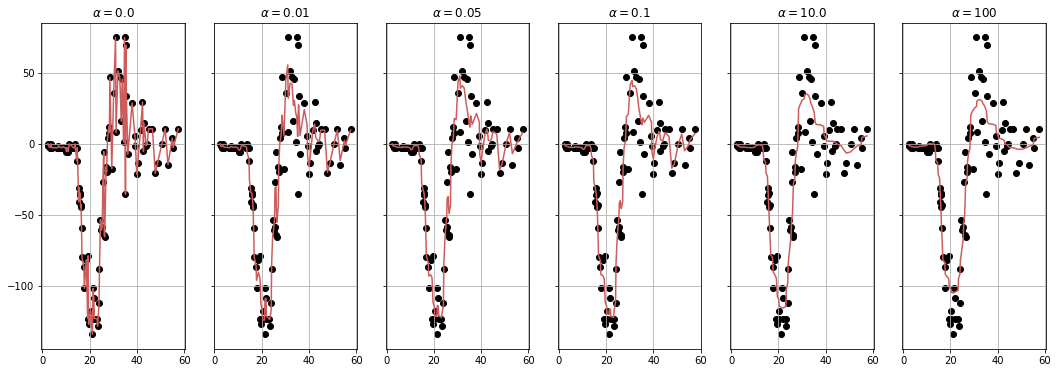

In [63]:
alphas = [0., 0.01, 0.05, 0.1, 10., 100]
f, axes = plt.subplots(1, 6, figsize=(18, 6), sharey=True)
for ax, alpha in zip(axes, alphas):
    g, gamma = solve_splines1(x, y, w, alpha=alpha)
    ax.scatter(x, y, color="k")
    ax.plot(x, g, color="indianred")
    ax.set_title(rf"$\alpha = {alpha}$")
    ax.grid()
plt.show()

We implement a GCV function that returns the GCV score and visualize the GCV score as a function of alpha.

In [64]:
def gcv(x, y, weights, alphas):
    """Compute GCV score for a grid of alphas"""

    n = len(x)
    gcv_alpha = []
    
    for alpha in alphas:
        g, gamma = solve_splines(x, y, weights, alpha=alpha)
        residuals = w *(y - g)
        mse = np.mean(residuals**2)
        
        R, Q = _construct_R_Q(x)
        trace = np.trace(np.linalg.inv(np.eye(n) + alpha *( Q @ np.linalg.inv(R) @ Q.T)))
        
        gcv_score = mse / (1 - trace / n)**2
        gcv_alpha.append(gcv_score)
    

    return gcv_alpha


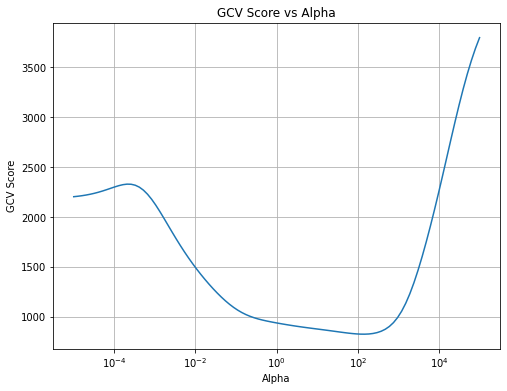

In [65]:
alphas = np.logspace(-5, 5, 100)
gcv_scores = gcv(x, y, w, alphas)

plt.figure(figsize=(8, 6))
plt.plot(alphas, gcv_scores)
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('GCV Score')
plt.title('GCV Score vs Alpha')
plt.grid()
plt.show()

### Custom regressor and cross validation with scikit-learn
To evaluate the best polynomial fit using cross-validation, we write our own scikit-learn and use scikit-learn's GridSearchCV to perform cross-validation. 


In [66]:
from sklearn.base import RegressorMixin, BaseEstimator
from sklearn.model_selection import GridSearchCV, LeaveOneOut

class PolynomialFit(BaseEstimator, RegressorMixin):
    def __init__(self, degree=5):
        self.degree = degree
        
    def fit(self, x, y, weights=None):

        self.coefficients_ = np.polyfit(x, y, self.degree, w=weights)
        return self

    def predict(self, x):
        y = np.polyval(self.coefficients_, x)
        return y

params = {"degree": np.arange(16)}

cv = LeaveOneOut()
poly_cv = GridSearchCV(PolynomialFit(), params, cv=cv, scoring="neg_mean_squared_error")
poly_cv.fit(x, y)
poly_cv.best_estimator_

PolynomialFit(degree=8)

 We plot the mean CV score as a function of the degree. 

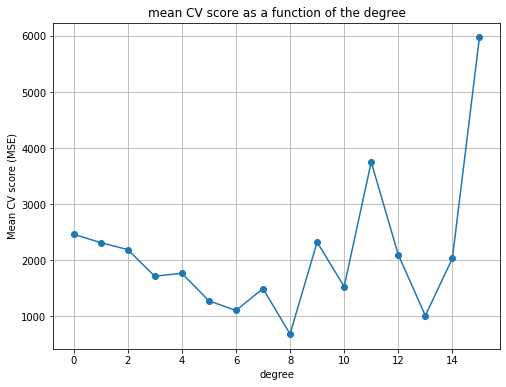

In [67]:
mean_test_score = poly_cv.cv_results_["mean_test_score"]
degrees = params["degree"]

plt.figure(figsize=(8, 6))
plt.plot(degrees, -mean_test_score, marker="o")
plt.xlabel("degree")
plt.ylabel("Mean CV score (MSE)")
plt.title("mean CV score as a function of the degree")
plt.grid()
plt.show()

We visualize the obtained best polynomial fit as well as the best cubic spline given by the GCV score minimizer.

In [68]:
# Best polynomial fit
best_poly = poly_cv.best_estimator_
best_poly_pred = best_poly.predict(x)

In [69]:
# Best cubic spline using the GCV score minimizer
alphas = np.logspace(-5, 5, 100)
gcv_scores = gcv(x, y, w, alphas)
best_alpha = alphas[np.argmin(gcv_scores)]
g_best_spline, gamma_best_spline = solve_splines(x, y, w, alpha=best_alpha)

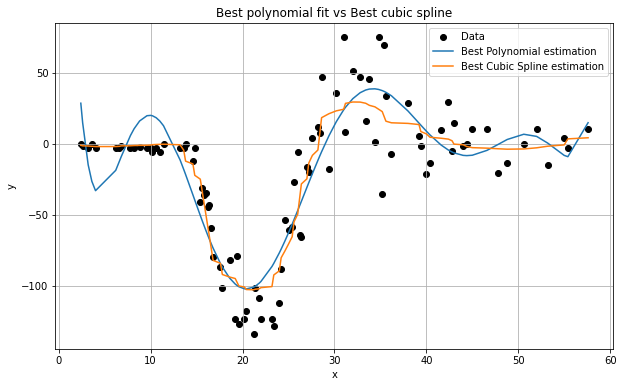

In [77]:
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color="k", label="Data")
plt.plot(x, best_poly_pred, label="Best Polynomial estimation")
plt.plot(x, g_best_spline, label="Best Cubic Spline estimation")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Best polynomial fit vs Best cubic spline")
plt.legend()
plt.grid()
plt.show()

Scikit-learn pipelines can be used to serialize several operations or models in one estimator. For ex:
```from sklearn.pipeline import Pipeline
pip = Pipeline([("Model_1_Name", Model1), ("Model_2_Name", Model2)])
pip.fit(X, y) ....
```
Using scikit-learn's `PolynomialFeatures` transformator, we wrote a model that performs a polynomial.

In [71]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

degree = 8

pip = Pipeline([("polynomial_features", PolynomialFeatures(degree=degree)),("linear_regression", LinearRegression())])
pip.fit(x.reshape(-1, 1), y)

y_pred = pip.predict(x.reshape(-1, 1))

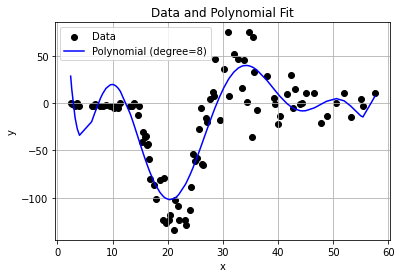

In [72]:
plt.scatter(x, y, color="k", label="Data")
plt.plot(x, y_pred, color="blue", label=f"Polynomial (degree={degree})")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Data and Polynomial Fit")
plt.legend()
plt.grid()
plt.show()

We then perform cross validation on the degree of this model using scikit-learn.

In [73]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut

pipe = Pipeline([("polynomial_features", PolynomialFeatures()), ("linear_regression", LinearRegression())])

param_grid = {"polynomial_features__degree": np.arange(1, 16)}
cv = LeaveOneOut()
grid_search = GridSearchCV(pipe, param_grid, cv=cv, scoring="neg_mean_squared_error")
grid_search.fit(x.reshape(-1, 1), y)


print("Best degree:", grid_search.best_params_["polynomial_features__degree"])
print("Best estimator:", grid_search.best_estimator_)

Best degree: 8
Best estimator: Pipeline(steps=[('polynomial_features', PolynomialFeatures(degree=8)),
                ('linear_regression', LinearRegression())])


We have the analytical expression of the NCS given $g$ and $\gamma$ to evaluate it on any data x0 $x$. We visualize it on a grid of a few hundred regular x0s.

In [74]:
def ncs(x0, x, y, weights, alpha=0.1):
    """
    x0 is the location where to evaluate the NCS
    """

    num_x0s = len(x)
    g_values, gamma_temp = solve_splines_naive(x, y, weights, alpha=alpha)
    gamma_values = np.zeros(num_x0s)
    gamma_values[1: num_x0s-1] = gamma_temp
    for i in range(num_x0s-1):
        if x0 >= x[i] and x0 <= x[i+1]:
            matrix = np.array([
                [x[i]*3, x[i]*2, x[i], 1],
                [x[i+1]*3, x[i+1]*2, x[i+1], 1],
                [6*x[i], 2, 0, 0],
                [6*x[i+1], 2, 0, 0]
            ])
            b_vec = [g_values[i], g_values[i+1], gamma_values[i], gamma_values[i+1]]
            coeffs = np.linalg.solve(matrix, b_vec)[::-1]
            return sum([coeffs[i] * (x0**i) for i in range(4)])
    if x0 < x[1]:
        slope = (g_values[1] - g_values[0]) / (x[1] - x[0])
        intercept = g_values[0] - slope * x[0]
        return slope * x0 + intercept
    elif x0 > x[num_x0s-2]:
        slope = (g_values[num_x0s-1] - g_values[num_x0s-2]) / (x[num_x0s-1] - x[num_x0s-2])
        intercept = g_values[num_x0s-2] - slope * x[num_x0s-2]
        return slope * x0 + intercept